# MNIST Benchmark

Summary of results for:

1. MNIST
2. Kuzushiji-MNIST
3. Fashion-MNIST

Notes on evaluation:

* Each dataset consists of multiple experiments.
* Each unique experiment can be identified by looking at the `train_kwargs` parameter.
    * Standard PyTorch sampling occurs when `{"sampler": False}`
    * Datasetq Heapq sampling occurs when `{"sampler": True}`
* Each unique experiment is conducted on 5 different seeds with per epoch data shuffling. 
    * The average of the five seeds are shown below. 
    
    
> Disclaimer: This notebook is kind of long but should be straightforward...

In [1]:
import pandas as pd
import torch
from torchvision import datasets, transforms

In [2]:
import sys

sys.path.append("../")

import summary

In [3]:
metrics = [
    "loss",
    "accuracy",
    "macro avg precision",
    "macro avg recall",
    "macro avg f1-score",
    "weighted avg precision",
    "weighted avg recall",
    "weighted avg f1-score",
    "time",
]

## 1. MNIST Experiment

In [4]:
dataset = "results"
experiment_name = "mnist_results"

In [5]:
topk = 25
index = 3

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

> Need to define model in order to load it...

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

### A. Train

In [8]:
arg_file = "args.json"
csv_file = "train_cache_map.csv"
model_file = "model.pth"

In [9]:
train_dataset = datasets.MNIST(
    "mnist",
    train=True,
    download=True,
    transform=transform,
)

#### i. Load data

In [10]:
hist_paths = summary.get_paths(csv_file, dataset, experiment_name)
arg_paths = summary.get_paths(arg_file, dataset, experiment_name)
model_paths = summary.get_paths(model_file, dataset, experiment_name)

In [11]:
hist_path = hist_paths[index]
arg_path = arg_paths[index]
model_path = model_paths[index]

In [12]:
hist = pd.read_csv(hist_path)
arg = summary.json_load(arg_path)
model = torch.load(model_path)

In [13]:
hist_visits = hist.sort_values(by=["visits"], ascending=False)
hist_loss = hist.sort_values(by=["loss"], ascending=False)

In [14]:
print(arg)

{'dataset': 'mnist', 'train_kwargs': {'batch_size': 64, 'sampler': True, 'shuffle': True, 'max_visits': 25}, 'test_kwargs': {'batch_size': 1000, 'sampler': True, 'steps': 1, 'shuffle': False}, 'n_trials': 1, 'epochs': 14, 'lr': 1.0, 'gamma': 0.7, 'no_cuda': False, 'seed': 268435456, 'save_dir': 'results', 'device': 'cuda'}


#### ii. View tables

##### a. Visits

In [15]:
v_ids = hist_visits["id"].tolist()[:topk]

**Model inference**

In [16]:
datas, targets = zip(*[train_dataset[id] for id in v_ids])
outputs = model(torch.stack(datas).to("cuda"))
preds = torch.argmax(outputs, axis=-1)

**View plots**

In [17]:
hist_visits

,trial,epoch,loss,visits,evict,id
55168,0,13,0.000165,112,True,55168
57683,0,13,0.000001,110,True,57683
36760,0,13,0.000190,106,True,36760
4460,0,13,0.095051,105,True,4460
46316,0,13,0.001006,104,True,46316
...,...,...,...,...,...,...
54726,0,13,-0.000000,10,False,54726
56982,0,13,-0.000000,10,False,56982
56983,0,13,-0.000000,10,False,56983
54725,0,13,-0.000000,10,False,54725


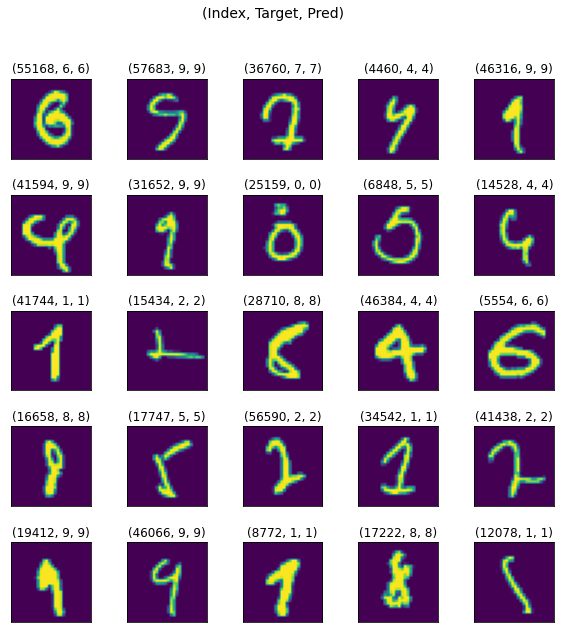

In [18]:
summary.plot_images_as_grid(
    datas, targets, preds, indices=v_ids, axes_pad=0.5, figsize=(10, 10)
)

---

##### a. Loss

In [19]:
l_ids = hist_loss["id"].tolist()[:topk]

**Model inference**

In [20]:
datas, targets = zip(*[train_dataset[id] for id in l_ids])
outputs = model(torch.stack(datas).to("cuda"))
preds = torch.argmax(outputs, axis=-1)

**View plots**

In [21]:
hist_loss

,trial,epoch,loss,visits,evict,id
7080,0,13,11.762264,39,True,7080
51248,0,13,7.553266,67,True,51248
34946,0,13,6.875380,36,True,34946
10994,0,13,6.606418,39,True,10994
53396,0,13,6.338652,38,True,53396
...,...,...,...,...,...,...
20409,0,13,-0.000000,11,False,20409
20410,0,13,-0.000000,11,False,20410
20411,0,13,-0.000000,11,False,20411
20412,0,13,-0.000000,11,False,20412


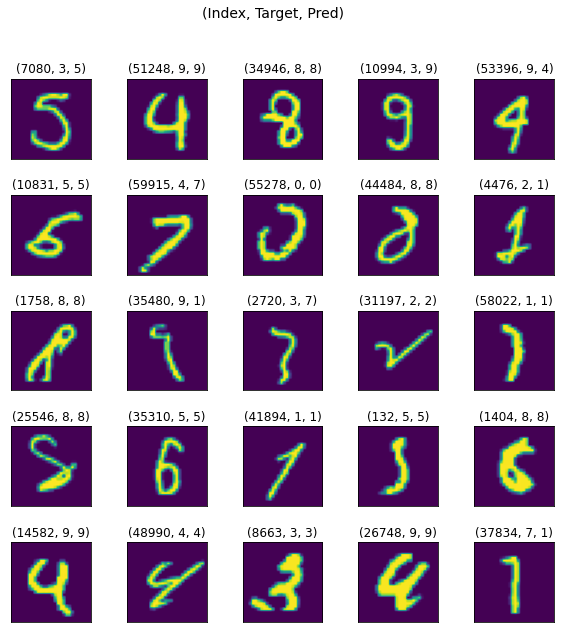

In [22]:
summary.plot_images_as_grid(
    datas, targets, preds, indices=l_ids, axes_pad=0.5, figsize=(10, 10)
)

### B. Test

In [23]:
arg_file = "args.json"
csv_file = "test_cache_map.csv"
model_file = "model.pth"

In [24]:
test_dataset = datasets.MNIST(
    "mnist",
    train=False,
    transform=transform,
)

#### i. Load data

In [25]:
hist_paths = summary.get_paths(csv_file, dataset, experiment_name)
arg_paths = summary.get_paths(arg_file, dataset, experiment_name)
model_paths = summary.get_paths(model_file, dataset, experiment_name)

In [26]:
hist_path = hist_paths[index]
arg_path = arg_paths[index]
model_path = model_paths[index]

In [27]:
hist = pd.read_csv(hist_path)
arg = summary.json_load(arg_path)
model = torch.load(model_path)

In [28]:
hist_visits = hist.sort_values(by=["visits"], ascending=False)
hist_loss = hist.sort_values(by=["loss"], ascending=False)

In [29]:
print(arg)

{'dataset': 'mnist', 'train_kwargs': {'batch_size': 64, 'sampler': True, 'shuffle': True, 'max_visits': 25}, 'test_kwargs': {'batch_size': 1000, 'sampler': True, 'steps': 1, 'shuffle': False}, 'n_trials': 1, 'epochs': 14, 'lr': 1.0, 'gamma': 0.7, 'no_cuda': False, 'seed': 268435456, 'save_dir': 'results', 'device': 'cuda'}


#### ii. View tables

> `Visits` are meaningless during model evaluation, so only the images with the largest loss are shown below.

##### a. Loss

In [30]:
l_ids = hist_loss["id"].tolist()[:topk]

**Model inference**

In [31]:
datas, targets = zip(*[test_dataset[id] for id in l_ids])
outputs = model(torch.stack(datas).to("cuda"))
preds = torch.argmax(outputs, axis=-1)

**View plots**

In [32]:
hist_loss

,trial,epoch,loss,visits,evict,id
1014,0,13,21.215130,14,False,1014
9729,0,13,18.068178,14,False,9729
2118,0,13,11.128398,14,False,2118
1530,0,13,10.099441,14,False,1530
3520,0,13,9.723230,14,False,3520
...,...,...,...,...,...,...
3788,0,13,-0.000000,14,False,3788
3787,0,13,-0.000000,14,False,3787
3786,0,13,-0.000000,14,False,3786
3784,0,13,-0.000000,14,False,3784


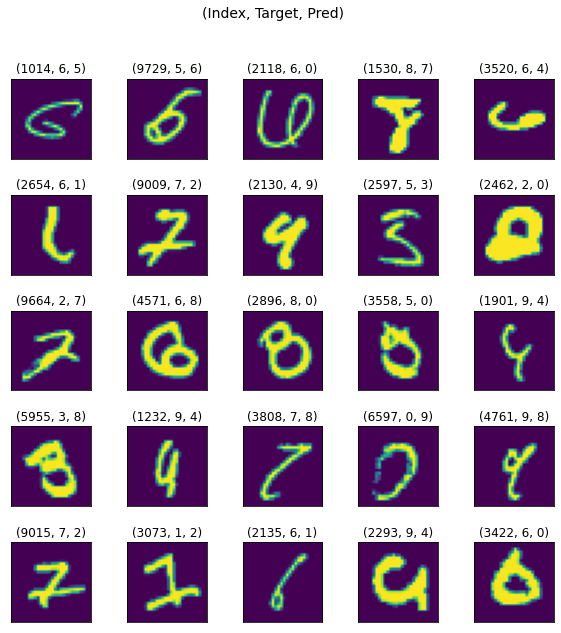

In [33]:
summary.plot_images_as_grid(
    datas, targets, preds, indices=l_ids, axes_pad=0.5, figsize=(10, 10)
)